<a href="https://colab.research.google.com/github/91htjung/AirportBusinessAnalytics/blob/main/01-Forecast_Longterm_Econometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings

try:
    import sktime
    import seaborn as sns
except:
    %pip install sktime
    %pip install pmdarima
    %pip install seaborn
    %pip install prophet
    import sktime
    import seaborn as sns

sns.set(rc={'figure.figsize':(12,4)})
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/91htjung/AirportBusinessAnalytics/main/Data_Longterm_Econometric.csv')
dataset['Period'] = pd.to_datetime(dataset['Period'])
dataset = dataset.set_index(['Period']).to_period("A")
dataset.head()

,Passenger,GDP,Population
Period,,,
2006,4560756348,60994370,6611696
2007,4908388831,63571790,6693580
2008,4923148695,64786270,6776098
2009,4832530008,63629480,6858496
2010,5282775193,66415110,6941248


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Population'>)

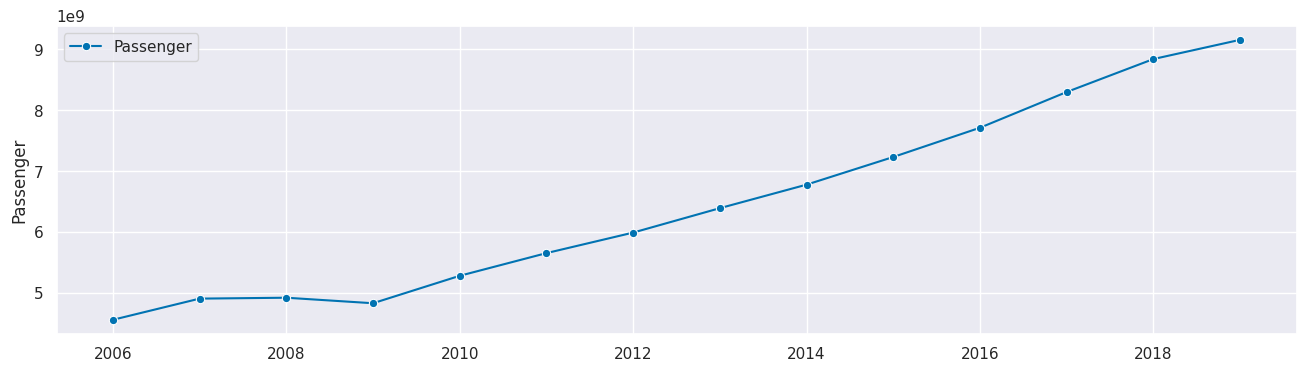

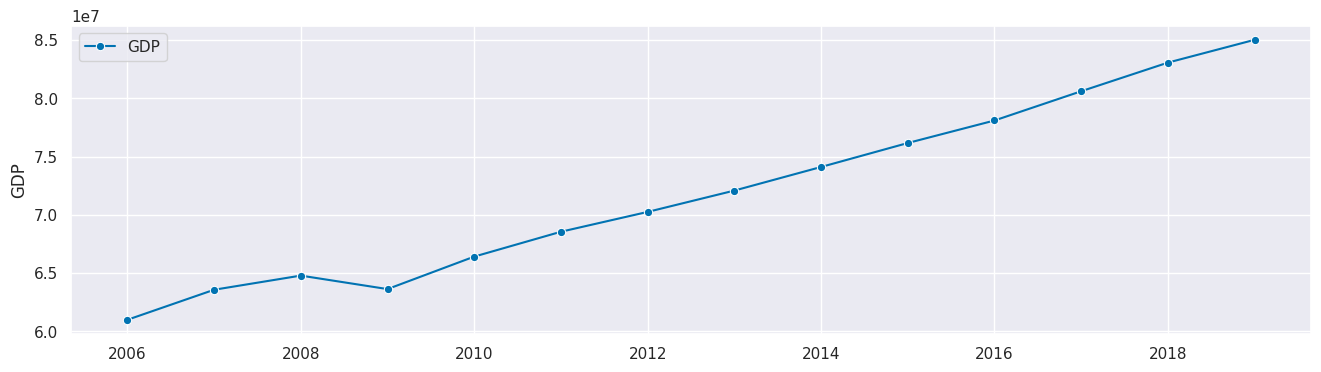

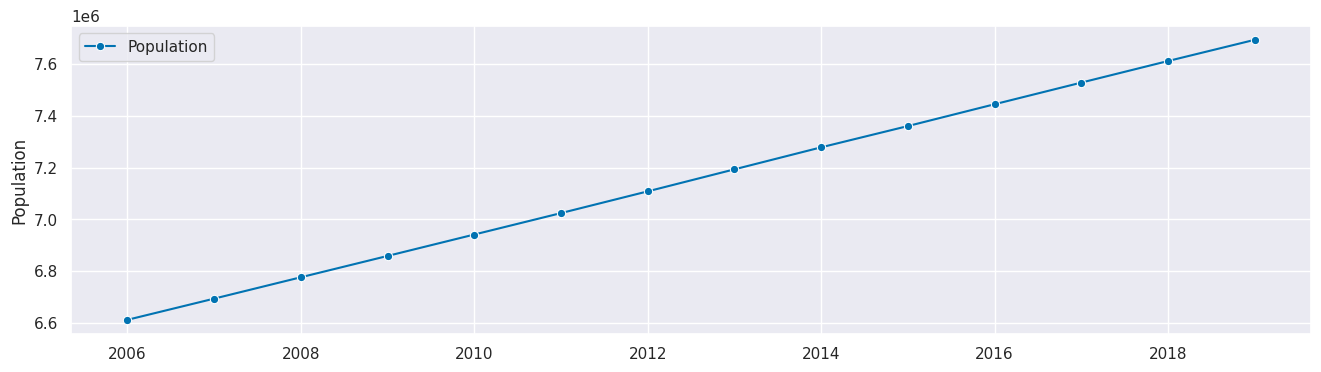

In [ ]:
from sktime.utils.plotting import plot_series

plot_series(dataset['Passenger'], labels=['Passenger'])
plot_series(dataset['GDP'], labels=['GDP'])
plot_series(dataset['Population'], labels=['Population'])